In [153]:
import numpy as np
import numpy as np
from sklearn.cluster import KMeans
from scipy.io import arff
from matplotlib import pyplot as plt

In [154]:
def get_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [155]:
class RBF:
    def __init__(self, train_data, train_label,testing_data, testing_label, num_of_classes,  num_of_clasters, std_from_clusters = True ):
        self.train_data = train_data
        self.train_label = train_label
        self.testing_data = testing_data
        self.testing_label = testing_label

        self.num_of_classes = num_of_classes
        self.num_of_clasters = num_of_clasters
        self.std_from_clusters = std_from_clusters
    
    def convert_to_one_hot(self, class_labels, num_of_classes):
        one_hot = np.zeros((len(class_labels), num_of_classes))
        for i in range(len(class_labels)):
            c = int(class_labels[i])
            one_hot[i][c] = 1
        
        return one_hot
    
    def rbf(self, train_data, centroids, std):
        distance = get_distance(train_data, centroids)

        return  np.exp(-(distance/ std) ** 2)
    
    def rbf_list(self, train_data, centroids, std_list):
        Rbs_list = []

        for data in train_data:
            Rbs_list.append([self.rbf(data, centroid, std) for (centroid, std) in zip(centroids, std_list)])
        
        return np.array(Rbs_list)
    

    def fit(self):
        kmeans =  KMeans(n_clusters = self.num_of_clasters, random_state = 0).fit(self.train_data)
        self.centroids = kmeans.cluster_centers_
        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.num_of_clasters), self.num_of_clasters)

        RBF_X = self.rbf_list(self.train_data, self.centroids, self.std_list)

        # self.weights = np.dot(np.linalg.pinv(RBF_X), self.convert_to_one_hot2(self.train_label, self.num_of_classes))
        # self.weights = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot2(self.train_label, self.num_of_classes)
        self.weights = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.train_label, self.num_of_classes)


        RBF_list_tst = self.rbf_list(self.testing_data, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.weights

        self.pred_ty = np.array([np.argmax(pred) for pred in self.pred_ty])

        diff = self.pred_ty - self.testing_label

        print("Accuracy: ", len(np.where(diff == 0)[0]) / len(diff) * 100)

In [156]:
data, meta = arff.loadarff("C:/Users/Ephrem's/Desktop/Repositories/Radial_Basis_Function_implementation/eeg+eye+state/EEG Eye State.arff")
data = np.array(data.tolist())
# data = np.char.decode(data.astype(str), 'utf-8')

data = data.astype(np.float32)
print(data)
train_x = data[0:12000, 0:14]
train_y = data[0:12000, 14]

test_x = data[12000:14980, 0:14]
test_y = data[12000:14980, 14]



[[4.32923e+03 4.00923e+03 4.28923e+03 ... 4.63590e+03 4.39385e+03
  0.00000e+00]
 [4.32462e+03 4.00462e+03 4.29385e+03 ... 4.63282e+03 4.38410e+03
  0.00000e+00]
 [4.32769e+03 4.00667e+03 4.29538e+03 ... 4.62872e+03 4.38923e+03
  0.00000e+00]
 ...
 [4.27744e+03 3.99077e+03 4.24667e+03 ... 4.59179e+03 4.33949e+03
  1.00000e+00]
 [4.28462e+03 3.99179e+03 4.25128e+03 ... 4.59641e+03 4.35077e+03
  1.00000e+00]
 [4.28769e+03 3.99744e+03 4.26000e+03 ... 4.59795e+03 4.35077e+03
  1.00000e+00]]


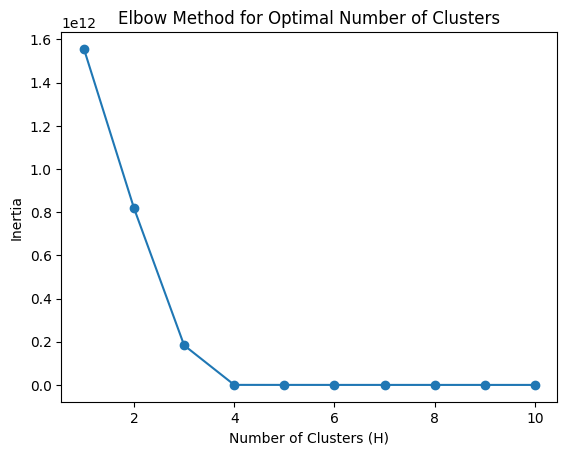

In [173]:
max_clusters = 10
inertias = []
for h in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=h, random_state=42,n_init="auto", max_iter=100)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (H)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


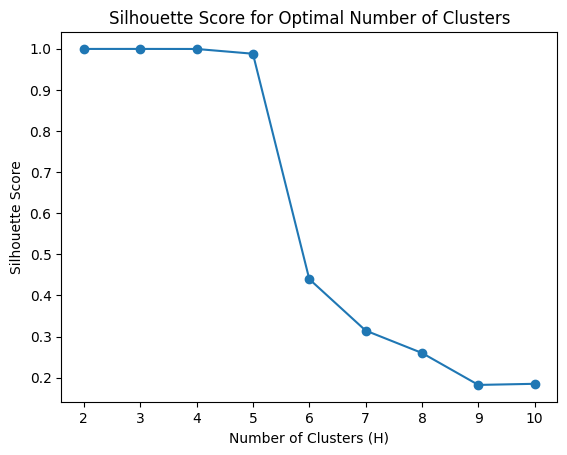

In [174]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt

max_clusters = 10
silhouette_scores = []
for h in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=h, random_state=0, n_init="auto")
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (H)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()


In [169]:

RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=2,
                     num_of_clasters = 15, std_from_clusters=False)

RBF_CLASSIFIER.fit()

c:\Users\Ephrem's\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy:  52.382550335570464
